## Importing necessary libraries 

In [1]:
!pip install xgboost

In [2]:
# Data manupulation and handling library
import pandas as pd  
import numpy as np

#Data visulation library
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sci

# Package to remove warings
import warnings
warnings.filterwarnings('ignore')

# VIF package for multicollinearity test
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data preprocessing library
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Model evaluation library
from sklearn.metrics  import mean_squared_error ,r2_score

# ML model libraries
from sklearn.linear_model import LinearRegression , Lasso ,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor , AdaBoostRegressor ,GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost

# Model Selection library
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,learning_curve

#Unsupervised ML library
from sklearn.cluster import KMeans


### Loading the data set


In [3]:
df = pd.read_excel('Capstone Project.xlsx')
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


### Problem Statment:
Build a machine learning model with the atmost accuracy to predict the strength of cement using the independent variables like cement,slag,ash,water,superplastic,coarseagg,fineagg and age. Hypermarmetrically tune the model and perforem learning curve analysis on the final model.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


Observations:
1. No missing value in the data set
2. All the features are numerical in nature so we dont need encoding

## Descriptive statistics

In [5]:
df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


Observations:
1. Scaling is necessary because the values are not in same range.
2. Slag,ash and age might have outliers as the mean and median values are quit far from each other.
3. Slag,ash andsuperplastic might not have outliersin lower whisker range as minimun and Q1 value is same.

### Building a custom summary function for EDA report

In [6]:
def descibe(input_df):
    cols = []
    for i in input_df.columns:
        if input_df[i].dtype != object:
            cols.append(i)
    
    result = pd.DataFrame(columns=cols,index=['Datatype','Count','Min','Q1','Q2','Mean','Q3','Max','Std','IQR','Range',
                                              'Skew','Kurt','Skewness comment','Kurtosis comment','Outlier comment'])
    
    for i in result.columns:
        result.loc['Datatype',i] = input_df[i].dtype
        result.loc['Count',i] = input_df[i].count()
        result.loc['Min',i] = input_df[i].min()
        result.loc['Q1',i] = input_df[i].quantile(0.25)
        result.loc['Q2',i] = input_df[i].quantile(0.5)
        result.loc['Mean',i] = input_df[i].mean()
        result.loc['Q3',i] = input_df[i].quantile(0.75)
        result.loc['Max',i] = input_df[i].max()
        result.loc['Std',i] = input_df[i].std()
        result.loc['IQR',i] = input_df[i].quantile(0.75) - input_df[i].quantile(0.25)
        result.loc['Range',i] = input_df[i].max() - input_df[i].min()
        result.loc['Skew',i] = input_df[i].skew()
        result.loc['Kurt',i] = input_df[i].kurt()
        
        
        #Adding comments for skewness
        if result.loc['Skew',i ] <= -1:
            sk_label = 'Highly negetively skewed'
        elif -1 < result.loc['Skew',i] <= -0.5:
            sk_label = 'moderately negetively skewed'
        elif -0.5 < result.loc['Skew',i] < 0:
            sk_label = 'approx. normal distribution(-ve)'
        elif 0 <= result.loc['Skew',i] < 0.5:
            sk_label = 'approx. normal distribution(+ve)'
        elif 0.5 <= result.loc['Skew',i] < 1:
            sk_label = 'moderately positively skewed'
        elif result.loc['Skew',i]  >= 1:
            sk_label = 'Highly positively skewed'
        else:
            sk_label = 'error'
        result.loc['Skewness comment',i] = sk_label
        
        
        #Adding comments for Kurtosis
        if result.loc['Kurt',i ] < -1:
            kt_label = ' Platykurtic'
        elif -1 <= result.loc['Kurt',i ] < 0:
            kt_label = 'Mesokurtic(-ve)'
        elif 0 <= result.loc['Kurt',i ] <= 1:
            kt_label = "Mesokurtic(+ve) "
        elif   result.loc['Kurt',i ] >= 1:
            kt_label = 'Leptokurtic'
        else:
            sk_label = 'error'
        result.loc['Kurtosis comment',i] = kt_label
        
        
        #Adding comments for Outliers
        lw = result.loc['Q1',i] - 1.5*result.loc['IQR',i]
        uw = result.loc['Q3',i] + 1.5*result.loc['IQR',i]
        if len([x for x in input_df[i] if x < lw or x > uw]) > 0:
            outlier_label = 'Have outliers'
        else:
            outlier_label = 'No outliers'
        
        result.loc['Outlier comment',i] = outlier_label
        
            
    display(result)
    

In [7]:
descibe(df)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
Datatype,float64,float64,float64,float64,float64,float64,float64,int64,float64
Count,1030,1030,1030,1030,1030,1030,1030,1030,1030
Min,102.0,0.0,0.0,121.8,0.0,801.0,594.0,1,2.33
Q1,192.375,0.0,0.0,164.9,0.0,932.0,730.95,7.0,23.71
Q2,272.9,22.0,0.0,185.0,6.4,968.0,779.5,28.0,34.445
Mean,281.167864,73.895825,54.18835,181.567282,6.20466,972.918932,773.580485,45.662136,35.817961
Q3,350.0,142.95,118.3,192.0,10.2,1029.4,824.0,56.0,46.135
Max,540.0,359.4,200.1,247.0,32.2,1145.0,992.6,365,82.6
Std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.17598,63.169912,16.705742
IQR,157.625,142.95,118.3,27.1,10.2,97.4,93.05,49.0,22.425


## Performing outlier treatment

In [8]:
def replace_outliers(df,col,method='quartile',strategy='median'):
    col_data = df[col]
    if method == 'quartile':
        Q2 = col_data.quantile(0.5)
        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        IQR = Q3 - Q1
        lw = Q1 - 1.5*IQR
        uw = Q3 + 1.5*IQR
        
    elif method == 'std':
        mean = col_data.mean()
        std = col_data.std()
        lw = mean - 2*std
        uw = mean + 2*std
    else:
        print('Pass a correct method')
    outlier = df.loc[(col_data < lw) | (col_data > uw),col]
    outlier_density = len(outlier)/len(df)
    
    if len(outlier) == 0:
        print('Feature' , col,'does not have any outlier')
    else:
        print(' Feature' , col,' have outlier')
        print('Total no of outliers in ',col,'are',len(outlier))
        print('Outlier percentage in ',col,'is',outlier_density)
        display(df.loc[(col_data < lw) | (col_data > uw)])
        
    if strategy == 'median':
        df.loc[(col_data < lw ),col] = Q2
        df.loc[(col_data > uw),col] = Q2
    elif strategy == 'mean':
        df.loc[(col_data < lw ),col] = mean
        df.loc[(col_data > uw),col] = mean
    else:
        print('Pass the correct strategy')
    return df
        

In [11]:
def odt_plot(df,col):
    f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(25,8))
    
    #Descriptive stactics box plot
    sns.boxplot(df[col],ax=ax1)
    ax1.set_title(col+' boxplot')
    ax1.set_xlabel('boxplot')
    ax1.set_ylabel('values')
    
    # Plotting histogram with outliers
    sns.distplot(df[col],ax=ax2,fit=sci.norm)
    ax2.axvline(df[col].mean(),color='green')
    ax2.axvline(df[col].median(),color='brown')
    ax2.set_title(col+' histogram with outliers')
    ax2.set_xlabel('values')
    ax2.set_ylabel('density')
    
    #Performing outlier treatment
    df_out = replace_outliers(df,col)
    
    # Plotting histogram without outliers
    sns.distplot(df_out[col],ax=ax3,fit=sci.norm)
    ax3.axvline(df_out[col].mean(),color='green')
    ax3.axvline(df_out[col].median(),color='brown')
    ax3.set_title(col+' histogram without outliers')
    ax3.set_xlabel('values')
    ax3.set_ylabel('density')
    
    plt.show()

Feature cement does not have any outlier


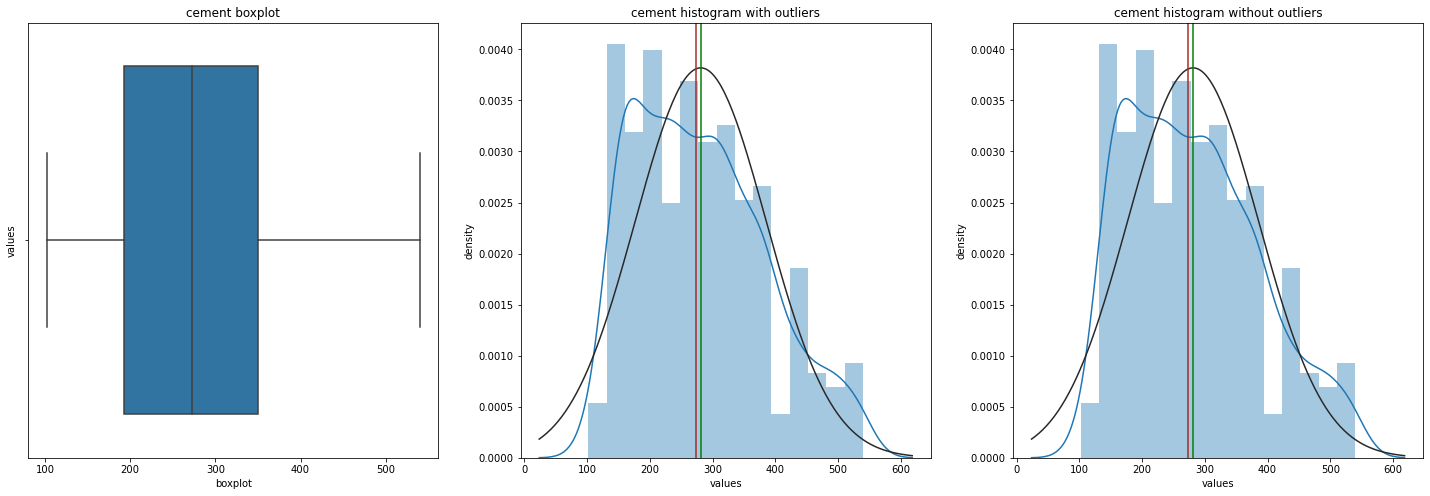

 Feature slag  have outlier
Total no of outliers in  slag are 2
Outlier percentage in  slag is 0.001941747572815534


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
918,239.6,359.4,0.0,185.7,0.0,941.6,664.3,28,39.44
990,239.6,359.4,0.0,185.7,0.0,941.6,664.3,7,25.42


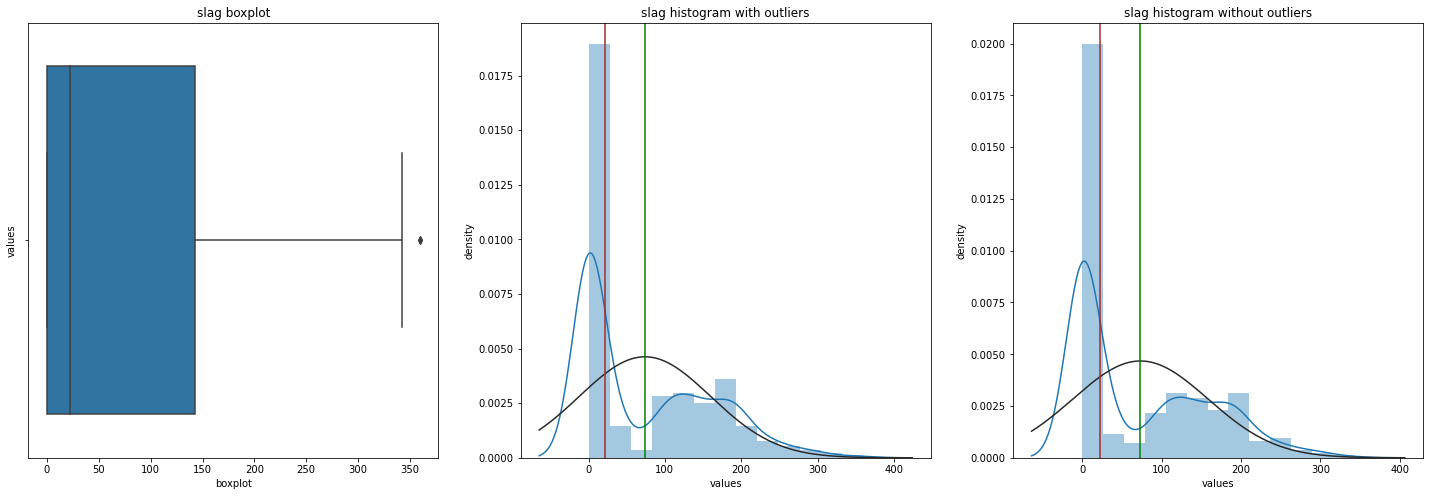

Feature ash does not have any outlier


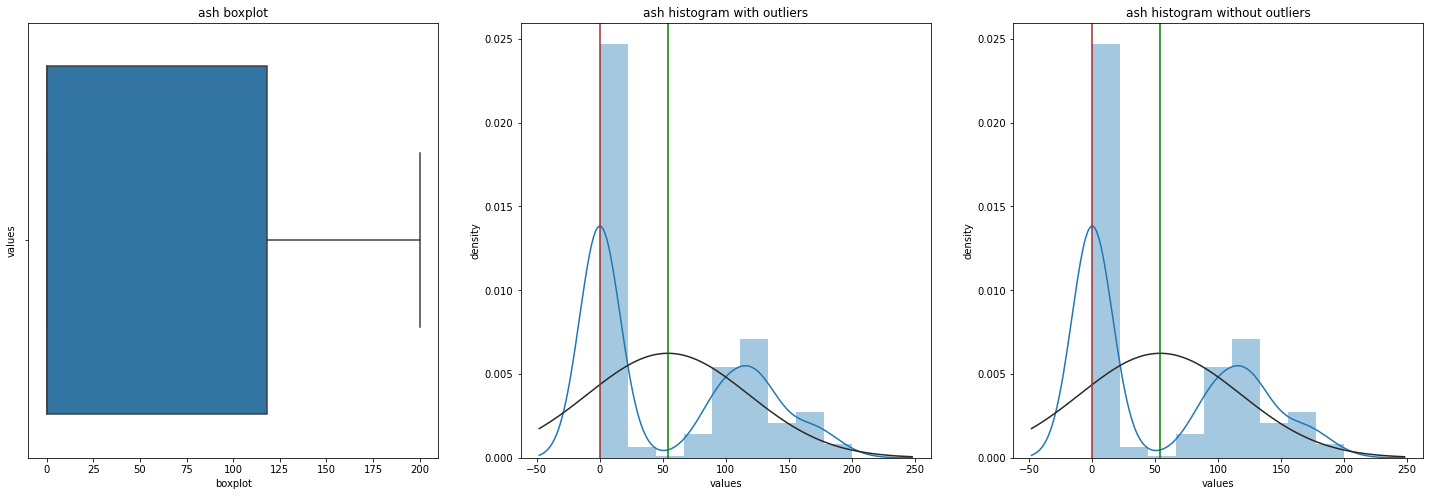

 Feature water  have outlier
Total no of outliers in  water are 9
Outlier percentage in  water is 0.008737864077669903


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
66,237.0,92.0,71.0,247.0,6.0,853.0,695.0,28,28.63
263,236.9,91.7,71.5,246.9,6.0,852.9,695.4,28,28.63
432,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,28,24.24
462,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,100,39.23
587,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,3,7.75
740,140.0,164.0,128.0,237.0,6.0,869.0,656.0,28,35.23
789,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,56,32.85
826,139.7,163.9,127.7,236.7,5.8,868.6,655.6,28,35.23
914,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,14,17.82


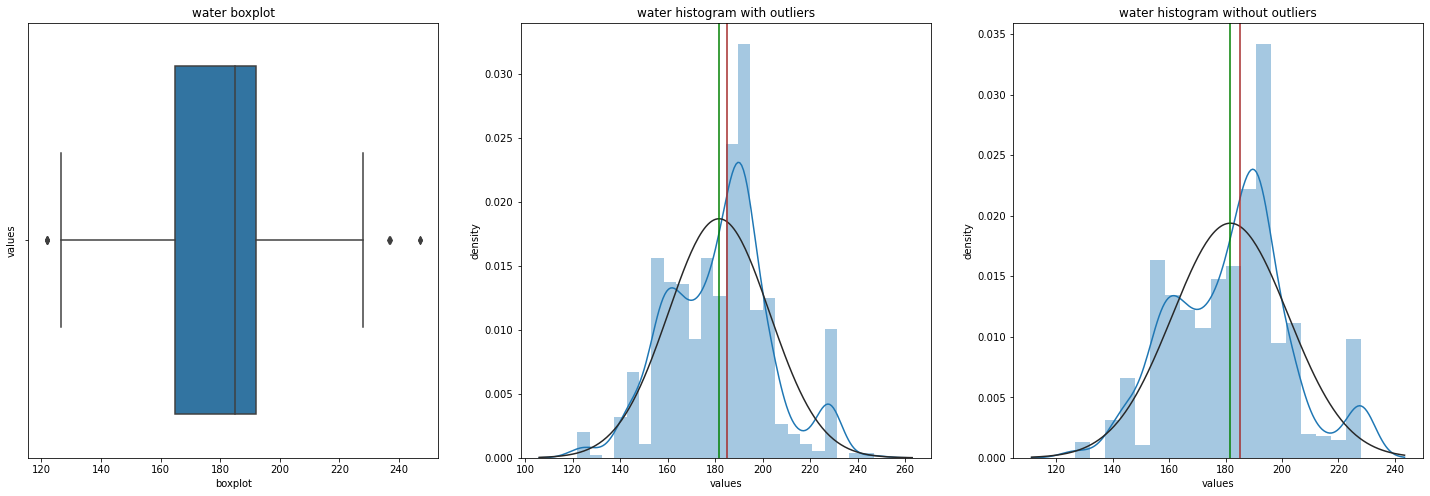

 Feature superplastic  have outlier
Total no of outliers in  superplastic are 10
Outlier percentage in  superplastic is 0.009708737864077669


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
44,531.3,0.0,0.0,141.8,28.2,852.1,893.7,91,59.2
156,531.3,0.0,0.0,141.8,28.2,852.1,893.7,28,56.4
232,469.0,117.2,0.0,137.8,32.2,852.1,840.5,56,69.3
292,469.0,117.2,0.0,137.8,32.2,852.1,840.5,91,70.7
538,531.3,0.0,0.0,141.8,28.2,852.1,893.7,7,46.9
744,469.0,117.2,0.0,137.8,32.2,852.1,840.5,7,54.9
816,469.0,117.2,0.0,137.8,32.2,852.1,840.5,28,66.9
838,531.3,0.0,0.0,141.8,28.2,852.1,893.7,56,58.8
955,469.0,117.2,0.0,137.8,32.2,852.1,840.5,3,40.2
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.3


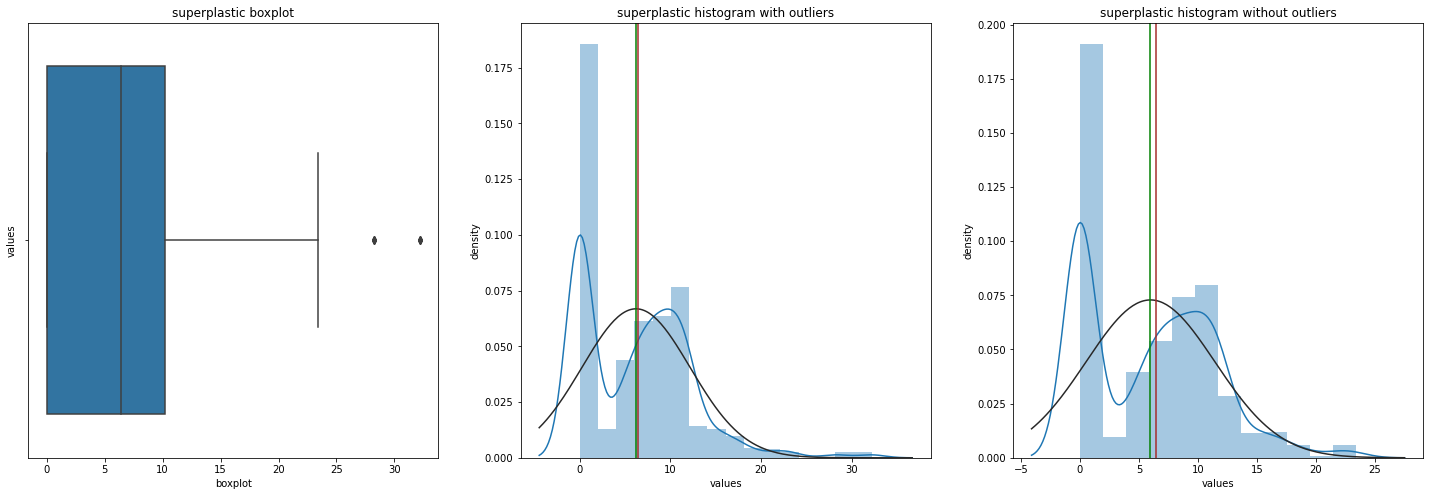

Feature coarseagg does not have any outlier


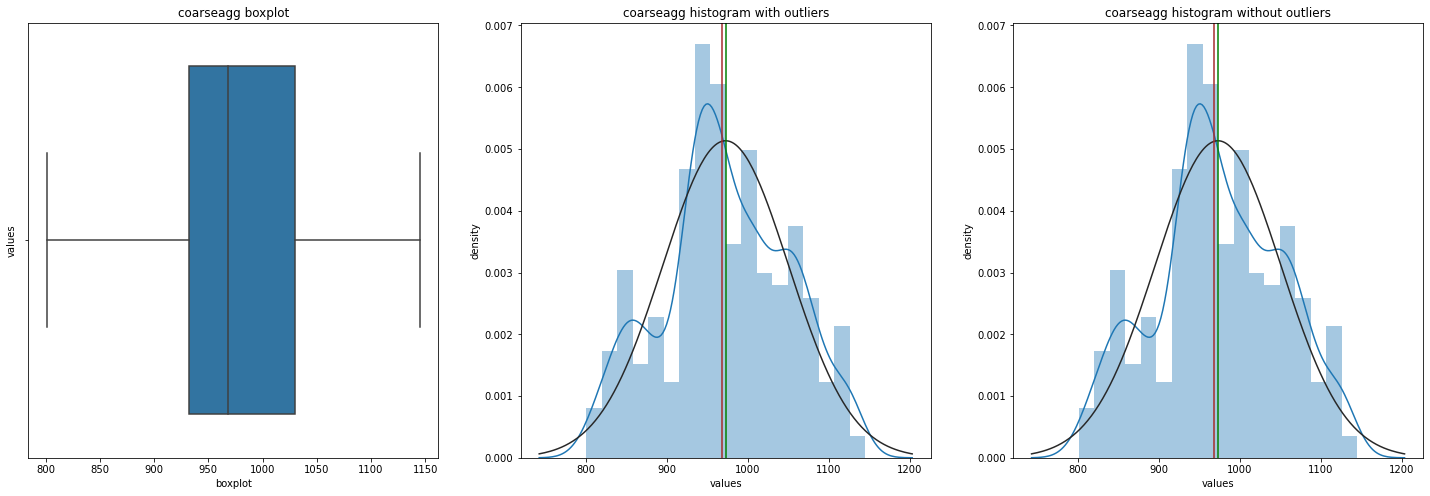

 Feature fineagg  have outlier
Total no of outliers in  fineagg are 5
Outlier percentage in  fineagg is 0.0048543689320388345


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
129,375.0,93.8,0.0,126.6,23.4,852.1,992.6,91,62.5
447,375.0,93.8,0.0,126.6,23.4,852.1,992.6,7,45.7
504,375.0,93.8,0.0,126.6,23.4,852.1,992.6,3,29.0
584,375.0,93.8,0.0,126.6,23.4,852.1,992.6,56,60.2
857,375.0,93.8,0.0,126.6,23.4,852.1,992.6,28,56.7


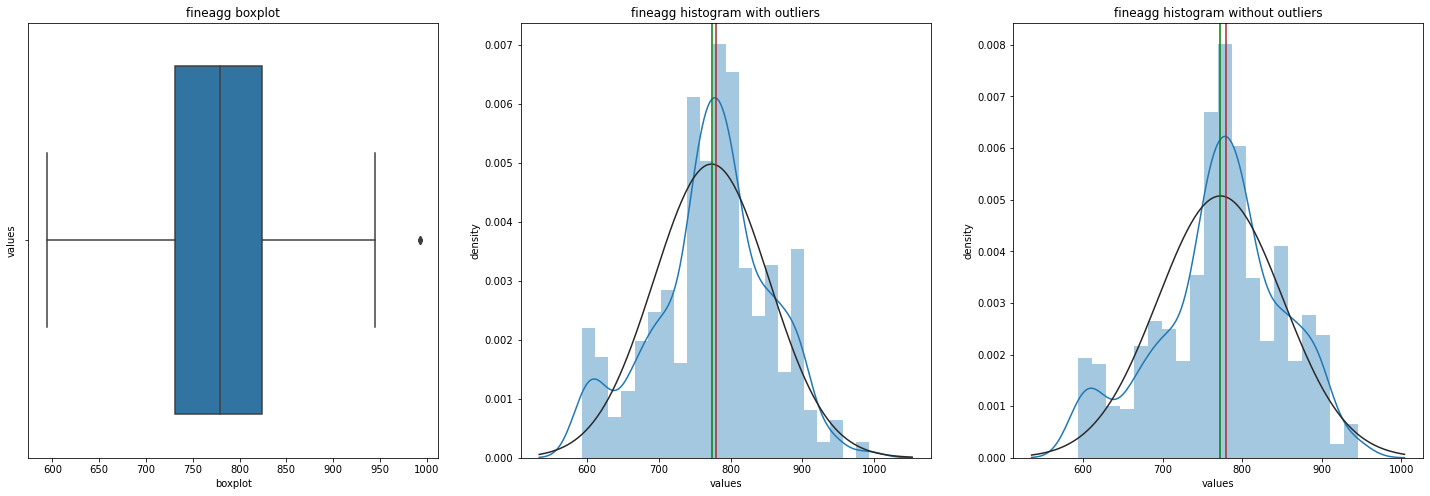

 Feature age  have outlier
Total no of outliers in  age are 59
Outlier percentage in  age is 0.05728155339805825


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
51,331.0,0.0,0.0,192.0,0.0,978.0,825.0,180,39.00
64,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
93,427.5,47.5,0.0,228.0,0.0,932.0,594.0,180,41.84
99,237.5,237.5,0.0,228.0,0.0,932.0,594.0,180,36.25
103,380.0,0.0,0.0,228.0,0.0,932.0,670.0,180,53.10
133,236.0,0.0,0.0,193.0,0.0,968.0,885.0,365,25.08
144,302.0,0.0,0.0,203.0,0.0,974.0,817.0,180,26.74
149,380.0,95.0,0.0,228.0,0.0,932.0,594.0,270,41.15
152,322.0,0.0,0.0,203.0,0.0,974.0,800.0,180,29.59
157,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


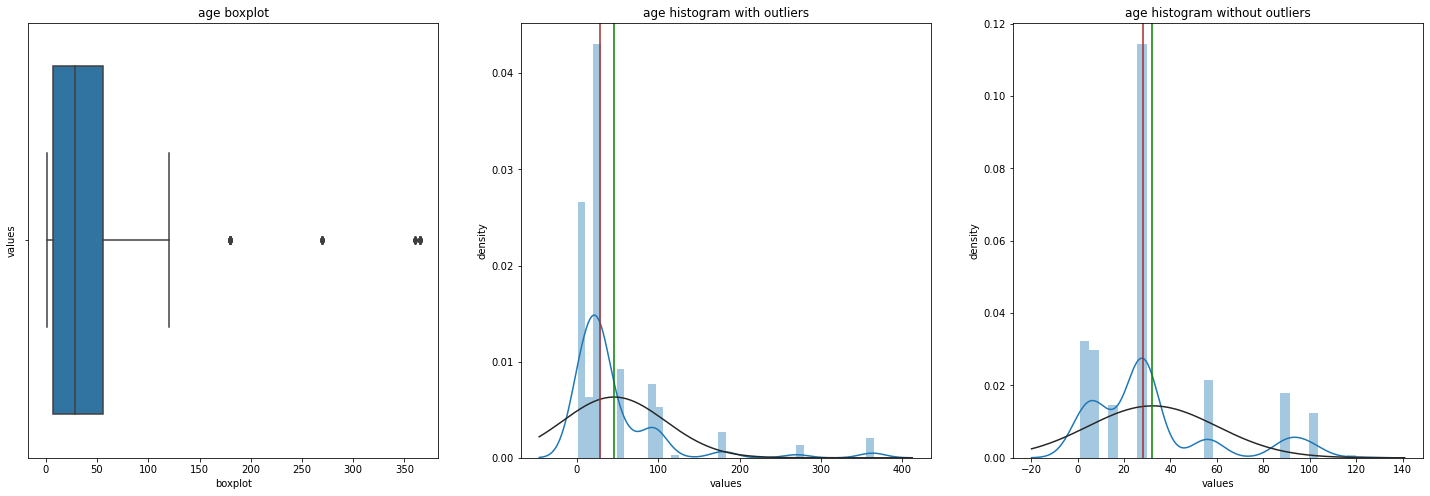

 Feature strength  have outlier
Total no of outliers in  strength are 4
Outlier percentage in  strength is 0.003883495145631068


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
192,315.0,137.0,0.0,145.0,5.9,1130.0,745.0,28,81.75
732,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
950,389.9,189.0,0.0,145.9,22.0,944.7,755.8,91,82.60
1003,323.7,282.8,0.0,183.8,10.3,942.7,659.9,56,80.20


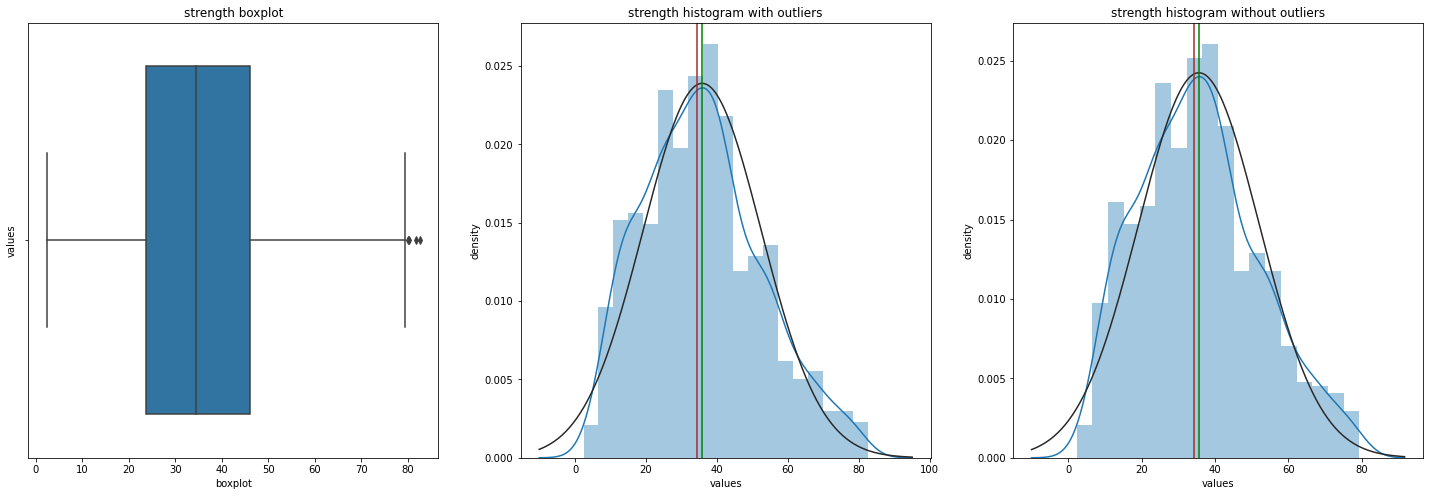

In [10]:
for col in df.columns:
    odt_plot(df,col)

## Multivariate analysis using regression

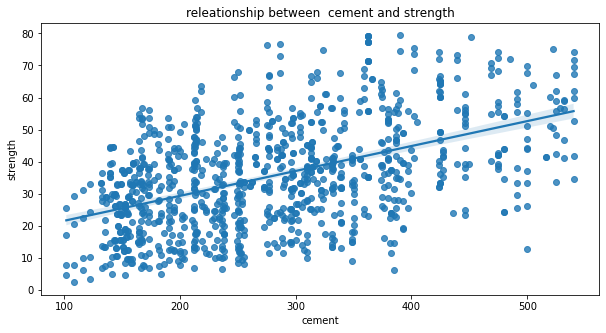

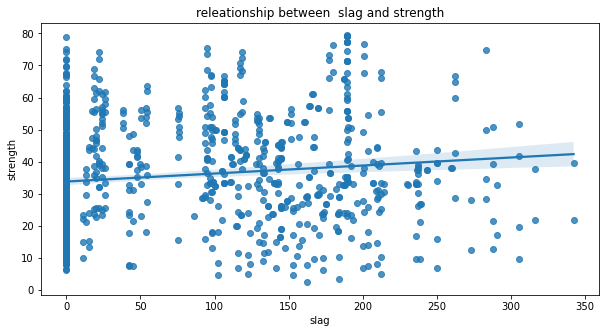

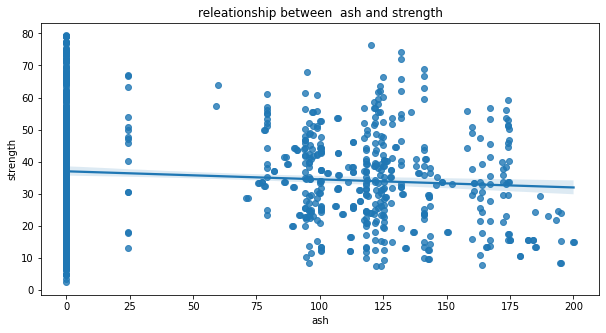

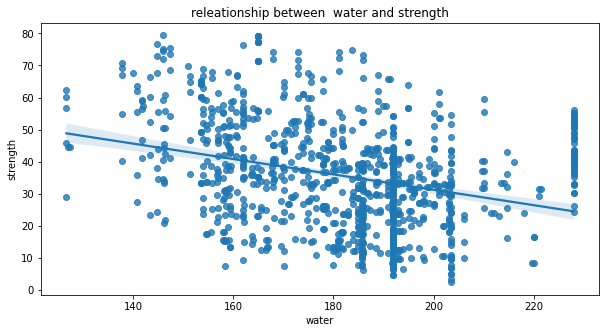

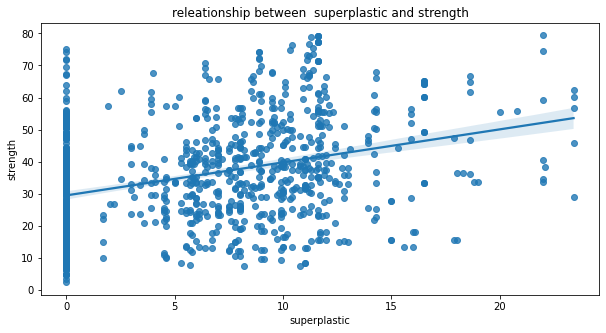

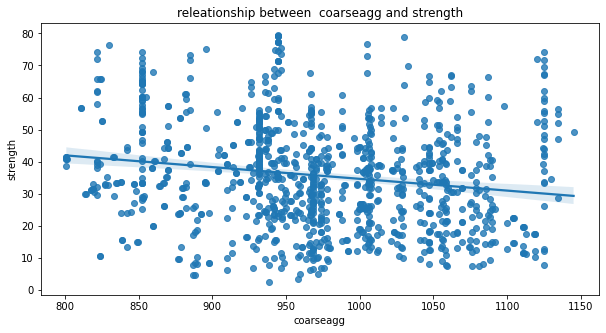

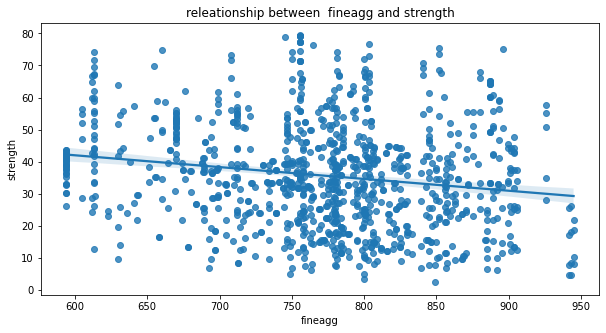

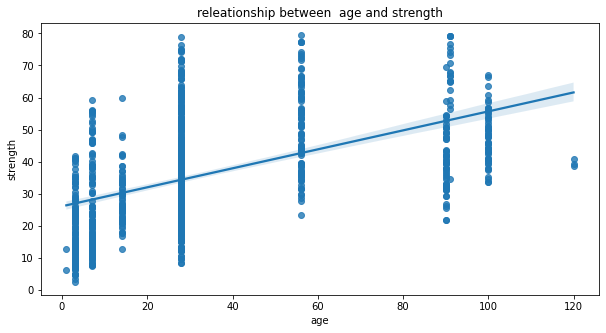

In [11]:
for col in df.columns:
    if col != 'strength':
        fig,ax1 = plt.subplots(figsize = (10,5))
        sns.regplot(x = df[col],y=df['strength'],ax=ax1).set_title(f'releationship between  {col} and strength')

Analysis:
1. Cement and strength are highly positiely coreleated
2. Slag and strength are positively coreleated
3. ash and strength are negatively coreleated
4. water and strength are highly negatively coreleated
5. superplastic and strength are highly positiely coreleated
6. corseagg and strength are highly negatively coreleated
7. fineagg  and strength are highly negatively coreleated
8. Age and strength are highly positiely coreleated


## Multicollinearity test
### Stage 1 test- Correlation heat map/matrix

<AxesSubplot:>

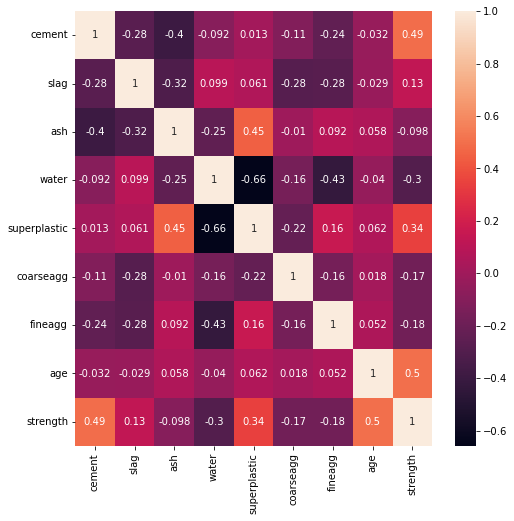

In [12]:
corr = df.corr()
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(corr,annot=True)

- ash and superplastic 45%
- superplastic and water 66%
- cement and ash 40%
- slag and ash 32%
- water and fine agg 43%
- Many independet features have collnearity more than 30% so we can conclude that multicollnearity exists as stage 1 result.


## Multicollinearity test 
### Stage 2- VIF
- Variance inflating factor(VIF) 
    Formula for VIF = 1/(1-r2score)
    Steps for VIF
    1. Regress every independent variable with each other and find the r2 score
    2. Find out the VIF using above formula
    3. If VIF is more tham 5 for any variable we can conclude that multicollinearity exists.

In [13]:
def VIF(features):
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif['Features'] = features.columns
    return vif.sort_values(['VIF'],ascending=False)

In [14]:
VIF(df.drop('strength',axis=1))

,VIF,Features
5,86.938582,coarseagg
3,81.963087,water
6,68.664404,fineagg
0,14.291158,cement
4,5.724145,superplastic
2,4.415840,ash
1,3.342314,slag
7,2.368372,age


# PCA

In [22]:
def pca1(x):
    n_com = len(x.columns)
    x = StandardScaler().fit_transform(x)
    
    for i in range(1,n_com):
        pca = PCA(n_components=i)
        p_com = pca.fit_transform(x)
        evr = np.cumsum(pca.explained_variance_ratio_)
        if evr[i - 1] > 0.9:
            n_components = i
            break
    print('Explained Variance Ratio after PCA is',evr)
    
    col = []
    for j in range(1,n_components+1):
        col.append('PC_'+ str(j))
    pca_df = pd.DataFrame(p_com,columns=col)
    return pca_df

In [23]:
transformed_df = pca1(df.drop('strength',axis=1))

Explained Variance Ratio after PCA is [0.27112429 0.44666571 0.60914114 0.73584634 0.85926016 0.97264602]


In [24]:
transformed_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
0,1.810919,1.331664,-1.284484,-0.306148,-0.067652,-0.886110
1,-1.823833,-0.573436,-1.058973,0.893130,-0.913984,-0.751061
2,-0.739819,-0.463200,-0.541643,-1.033210,-0.308068,0.611045
3,2.766368,0.602978,-0.512532,0.008806,0.086415,0.850548
4,0.892523,0.966627,-0.863624,1.148561,-0.064439,-1.221228


In [25]:
transformed_df = transformed_df.join(df['strength'],how='left')

In [26]:
transformed_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,strength
0,1.810919,1.331664,-1.284484,-0.306148,-0.067652,-0.886110,29.89
1,-1.823833,-0.573436,-1.058973,0.893130,-0.913984,-0.751061,23.51
2,-0.739819,-0.463200,-0.541643,-1.033210,-0.308068,0.611045,29.22
3,2.766368,0.602978,-0.512532,0.008806,0.086415,0.850548,45.85
4,0.892523,0.966627,-0.863624,1.148561,-0.064439,-1.221228,18.29


## Model Building
1. Train Test Split
2. Crossvalidation
3. Hyperparameter Tuning

In [27]:
def train_and_test_split(data,t_col,testsize = 0.3):
    x = data.drop(t_col,axis=1)
    y = data[t_col]
    return train_test_split(x,y,test_size = testsize,random_state = 0)

In [28]:
def build_model(model_name,estimator,data,t_col):
    x_train,x_test,y_train,y_test = train_and_test_split(data,t_col)
    estimator.fit(x_train,y_train)
    y_pred = estimator.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    r2score = r2_score(y_test,y_pred)
    
    return [model_name,rmse,r2score]

In [29]:
build_model(model_name='Linear Regression',estimator= LinearRegression(),data = transformed_df,t_col = 'strength')

['Linear Regression', 9.268894457764832, 0.6733375978100167]

In [30]:
def multiple_models(data,t_col):
    col_names = ['Model name','RMSE','R2 score']
    result = pd.DataFrame(columns=col_names)
    result.loc[len(result)] = build_model('Linear Regression', LinearRegression(),data ,t_col )
    result.loc[len(result)] = build_model('Lasso', Lasso(),data ,t_col)
    result.loc[len(result)] = build_model('Ridge Regression ', Ridge(),data ,t_col)
    result.loc[len(result)] = build_model('DT Regression', DecisionTreeRegressor(),data ,t_col)
    result.loc[len(result)] = build_model('KN Regression', KNeighborsRegressor(),data ,t_col)
    result.loc[len(result)] = build_model('SV Regression', SVR(),data ,t_col)
    result.loc[len(result)] = build_model('RF Regression', RandomForestRegressor(),data ,t_col)
    result.loc[len(result)] = build_model('ADB Regression', AdaBoostRegressor(),data ,t_col)
    result.loc[len(result)] = build_model('GB Regression', GradientBoostingRegressor(),data ,t_col)
    result.loc[len(result)] = build_model('XGB Regression', SVR(),data ,t_col)
    return result.sort_values(['R2 score'],ascending=False)

In [32]:
multiple_models(transformed_df,'strength')

,Model name,RMSE,R2 score
6,RF Regression,6.160528,0.855696
8,GB Regression,6.632406,0.832743
4,KN Regression,7.811682,0.767976
3,DT Regression,8.355635,0.734538
7,ADB Regression,8.421565,0.730332
5,SV Regression,9.051841,0.688458
9,XGB Regression,9.051841,0.688458
0,Linear Regression,9.268894,0.673338
2,Ridge Regression,9.270519,0.673223
1,Lasso,9.635047,0.647019


## Cross validation

In [33]:
def k_fold_cv(x,y,fold=10):
   
    score_lr = cross_val_score(LinearRegression(),x,y,cv=fold)
    score_ls = cross_val_score(Lasso(),x,y,cv=fold)
    score_rd = cross_val_score(Ridge(),x,y,cv=fold)
    score_xg = cross_val_score(XGBRegressor(),x,y,cv=fold)
    score_gb = cross_val_score(GradientBoostingRegressor(),x,y,cv=fold)
    score_adb = cross_val_score(AdaBoostRegressor(),x,y,cv=fold)
    score_rf = cross_val_score(RandomForestRegressor(),x,y,cv=fold)
    score_dt = cross_val_score(DecisionTreeRegressor(),x,y,cv=fold)
    score_knn = cross_val_score(KNeighborsRegressor(),x,y,cv=fold)
    score_svr = cross_val_score(SVR(),x,y,cv=fold)

    model_names = ['Linear Reg.', 'Lasso','Ridge','XGboost','Gradient','Adaboost','Random Forest','DTR','KNN','SVR']
    scores = [score_lr,score_ls,score_rd,score_xg,score_gb,score_adb,score_rf,score_dt,score_knn,score_svr]
    result = []
    
    for i in range(len(model_names)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_name = model_names[i]
        result.append([m_name,score_mean,score_std])
    
    k_fold_df = pd.DataFrame(result,columns=['Model Name','Avg. R2','STD R2 score'])
    
    return k_fold_df.sort_values(['Avg. R2'],ascending=False)


In [34]:
k_fold_cv(transformed_df.drop('strength',axis=1),transformed_df['strength'])

,Model Name,Avg. R2,STD R2 score
3,XGboost,0.873262,0.036061
6,Random Forest,0.868396,0.030436
4,Gradient,0.829229,0.050493
7,DTR,0.771085,0.064481
8,KNN,0.767853,0.055737
5,Adaboost,0.733940,0.033770
9,SVR,0.703117,0.042765
2,Ridge,0.663935,0.059437
0,Linear Reg.,0.663928,0.059476
1,Lasso,0.649837,0.049887


## Hyperparameneter tuning

In [35]:
def tunning(x,y,fold=10):
    param_xgboost = {'alpha':[0,1],'gamma':[0,10,20,30,40,50],'reg_lambda':[0,1]}
    param_gboost = {'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    param_rf = {'n_estimators':[50,100,150],'max_features':['auto','log2']}
    
    tune_xgb = GridSearchCV(XGBRegressor(),param_xgboost,cv=fold)
    tune_gb = GridSearchCV(GradientBoostingRegressor(),param_gboost,cv=fold)
    tune_rf = GridSearchCV(RandomForestRegressor(),param_rf,cv=fold)
    
    tune_xgb.fit(x,y)
    tune_gb.fit(x,y)
    tune_rf.fit(x,y)
    
    tuned = [tune_xgb,tune_gb,tune_rf]
    models = ['Xgboost','Gboost','Random Forest']
    
    for i in range(len(tuned)):
        print('Models :',models[i])
        print('Best params :',tuned[i].best_params_)


In [37]:
tunning(transformed_df.drop('strength',axis=1),transformed_df['strength'])


Models : Xgboost
Best params : {'alpha': 1, 'gamma': 0, 'reg_lambda': 1}
Models : Gboost
Best params : {'alpha': 0.6}
Models : Random Forest
Best params : {'max_features': 'auto', 'n_estimators': 100}


In [38]:
def cv_hpt(x,y,fold=10):
    score_lr = cross_val_score(LinearRegression(),x,y,cv=fold)
    score_ls = cross_val_score(Lasso(),x,y,cv=fold)
    score_rd = cross_val_score(Ridge(),x,y,cv=fold)
    score_xg = cross_val_score(XGBRegressor(alpha=1,gamma=0,reg_lambda=1),x,y,cv=fold)
    score_gb = cross_val_score(GradientBoostingRegressor(alpha=0.8),x,y,cv=fold)
    score_adb = cross_val_score(AdaBoostRegressor(),x,y,cv=fold)
    score_rf = cross_val_score(RandomForestRegressor(max_features='auto',n_estimators=150),x,y,cv=fold)
    score_dt = cross_val_score(DecisionTreeRegressor(),x,y,cv=fold)
    score_knn = cross_val_score(KNeighborsRegressor(),x,y,cv=fold)
    score_svr = cross_val_score(SVR(),x,y,cv=fold)

    model_names = ['Linear Reg.', 'Lasso','Ridge','XGboost','Gradient','Adaboost','Random Forest','DTR','KNN','SVR']
    scores = [score_lr,score_ls,score_rd,score_xg,score_gb,score_adb,score_rf,score_dt,score_knn,score_svr]
    result = []
    
    for i in range(len(model_names)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_name = model_names[i]
        result.append([m_name,score_mean,score_std])
    
    k_fold_df = pd.DataFrame(result,columns=['Model Name','Avg. R2','STD R2 score'])
    
    return k_fold_df.sort_values(['Avg. R2'],ascending=False)

In [39]:
cv_hpt(transformed_df.drop('strength',axis=1),transformed_df['strength'])

,Model Name,Avg. R2,STD R2 score
3,XGboost,0.877997,0.031728
6,Random Forest,0.866138,0.032677
4,Gradient,0.828950,0.050144
7,DTR,0.769736,0.062935
8,KNN,0.767853,0.055737
5,Adaboost,0.729453,0.034867
9,SVR,0.703117,0.042765
2,Ridge,0.663935,0.059437
0,Linear Reg.,0.663928,0.059476
1,Lasso,0.649837,0.049887


# Clustring

<AxesSubplot:xlabel='cement', ylabel='strength'>

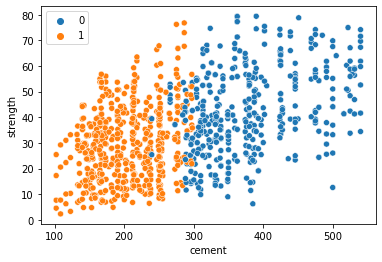

In [40]:
labels = KMeans(n_clusters=2,random_state=2)
cluster = labels.fit_predict(df.drop('strength',axis=1))
sns.scatterplot(x=df['cement'],y=df['strength'],hue=cluster)

In [41]:
def clustering(x,t_col,cluster):
    column = list(set(list(x.columns)) - set(['strength']))
    r = int(len(column)/2)
    if len(column)%2 == 0:
        r = r
    else:
        r += 1
    f,ax = plt.subplots(r,2,figsize =(15,15))
    a = 0
    for row in range(r):
        for col in range(0,2):
            if a != len(column):
                ax[row][col].scatter(x[t_col],x[column[a]],c=cluster)
                ax[row][col].set_xlabel(t_col)
                ax[row][col].set_ylabel(column[a])
                a += 1
                
                                

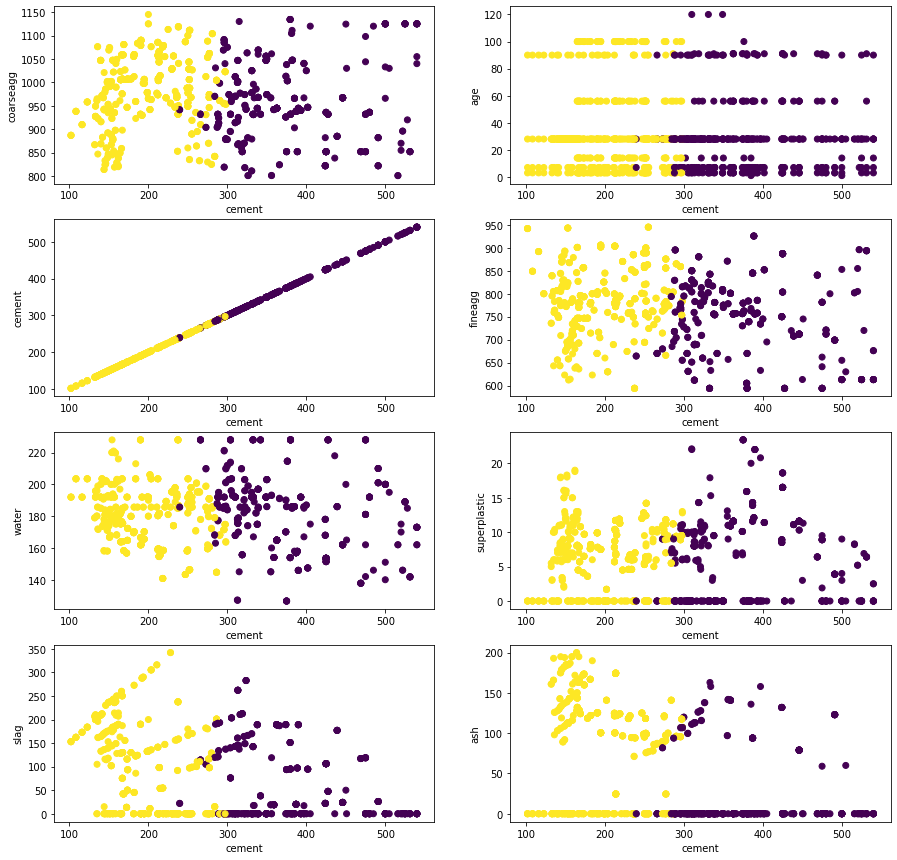

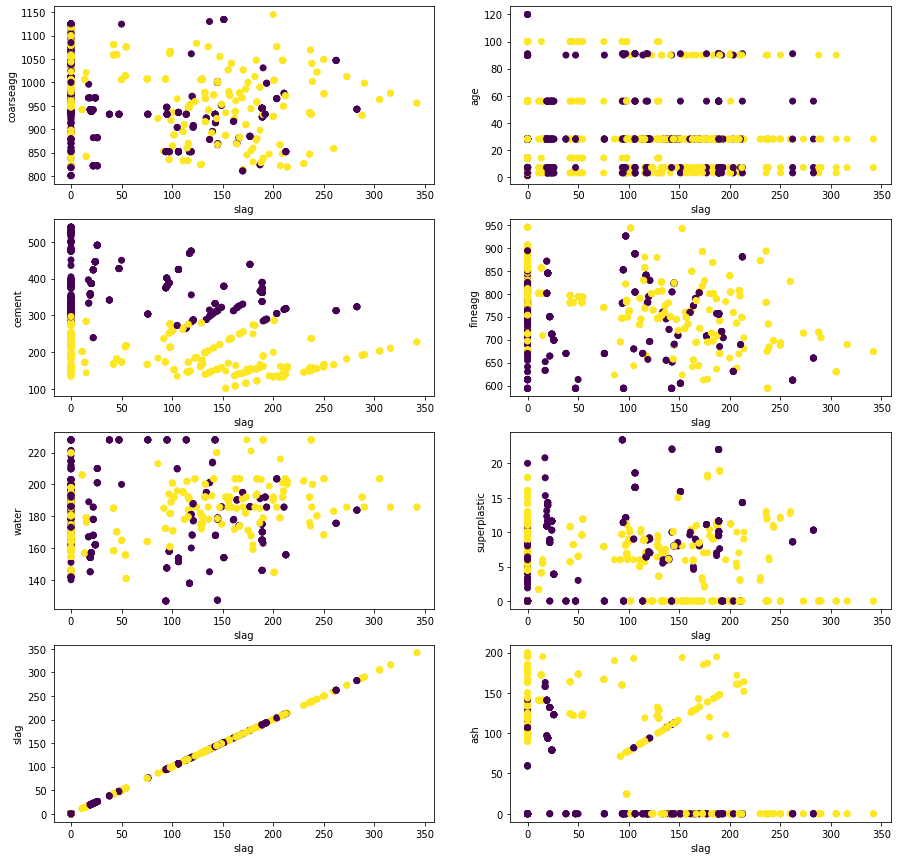

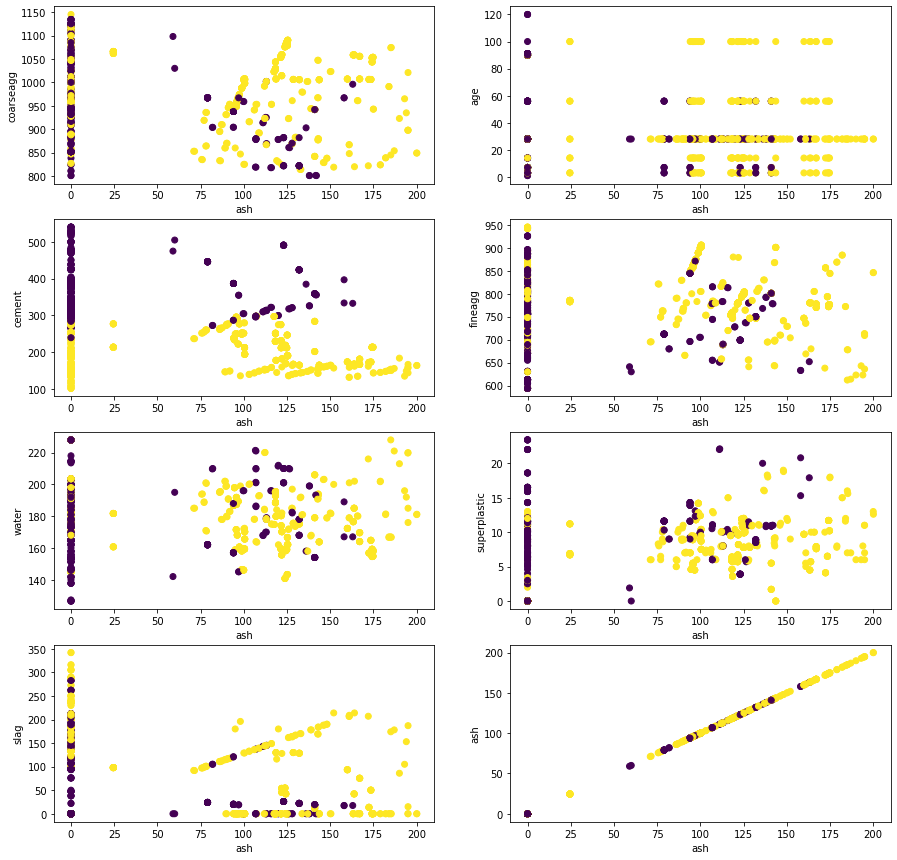

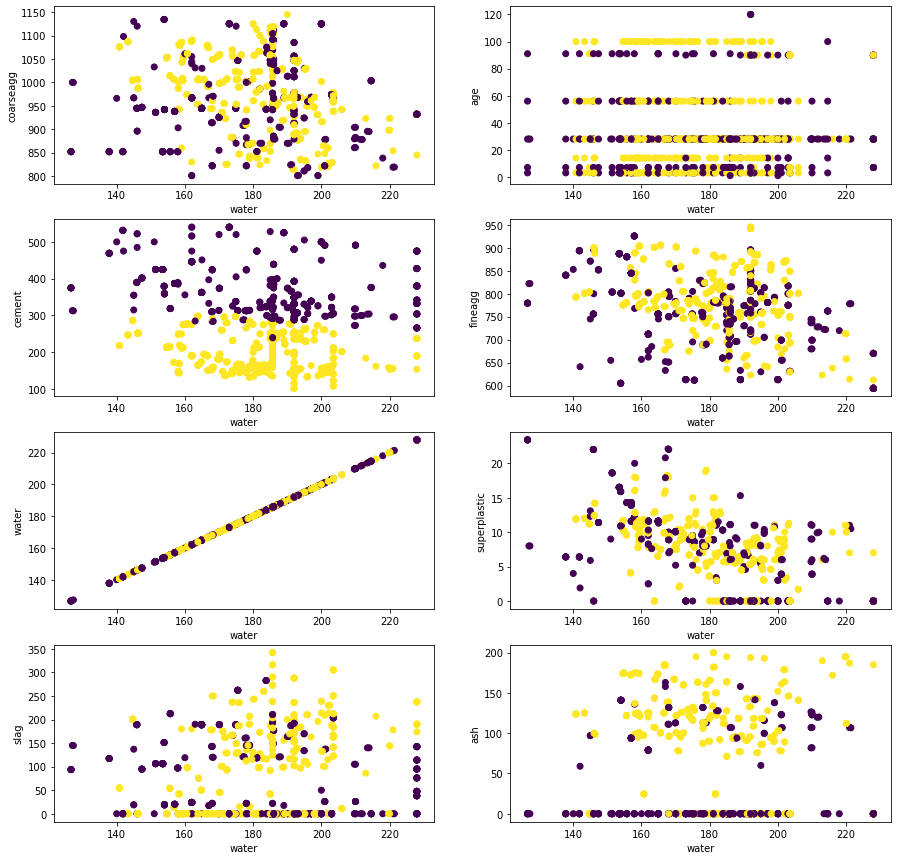

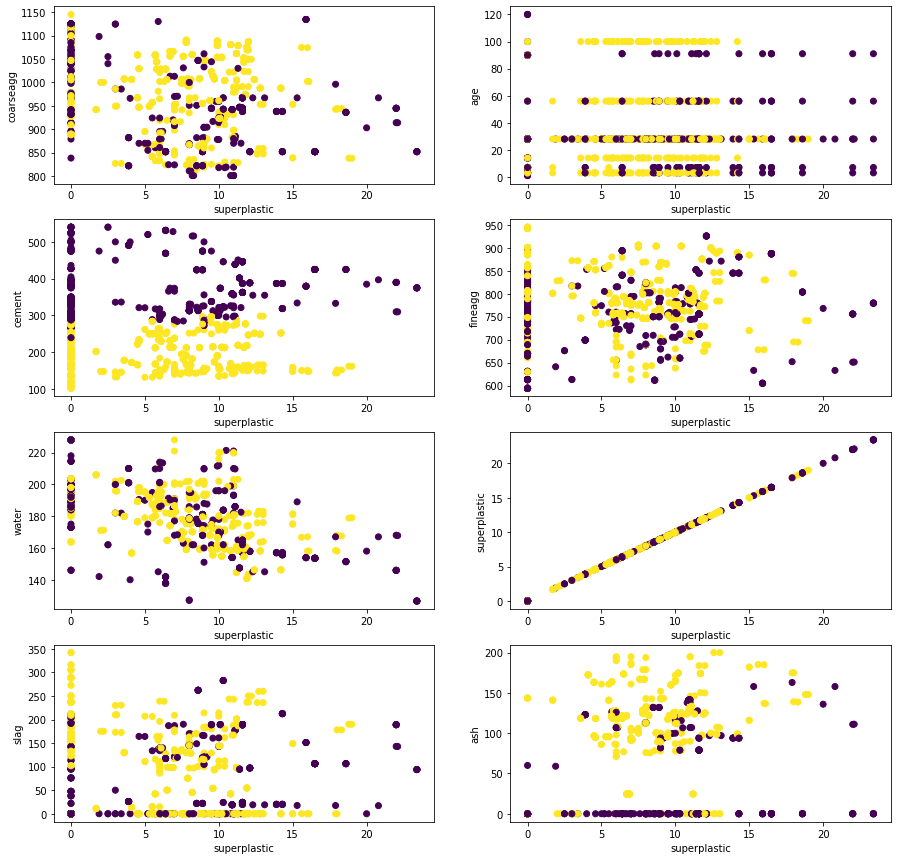

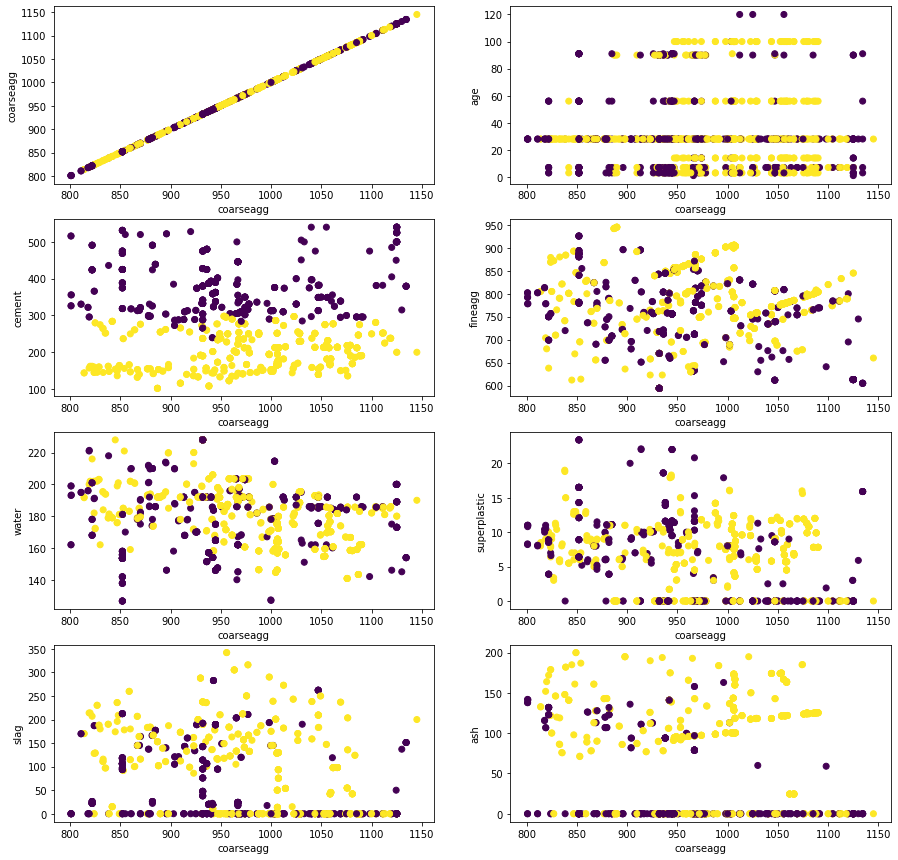

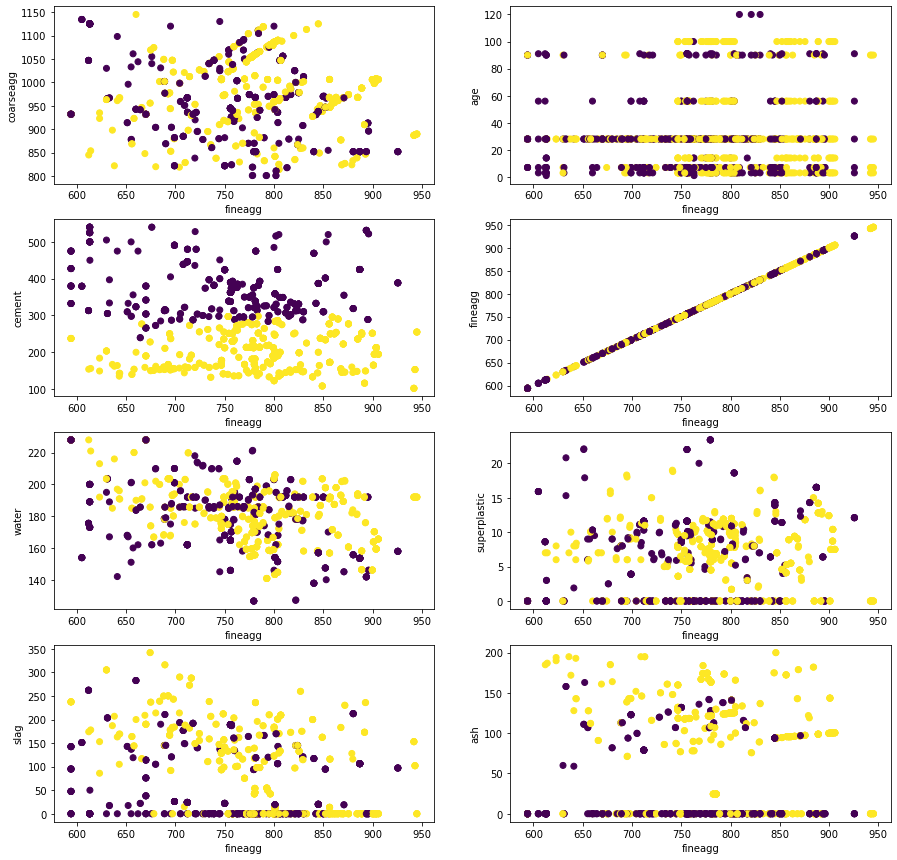

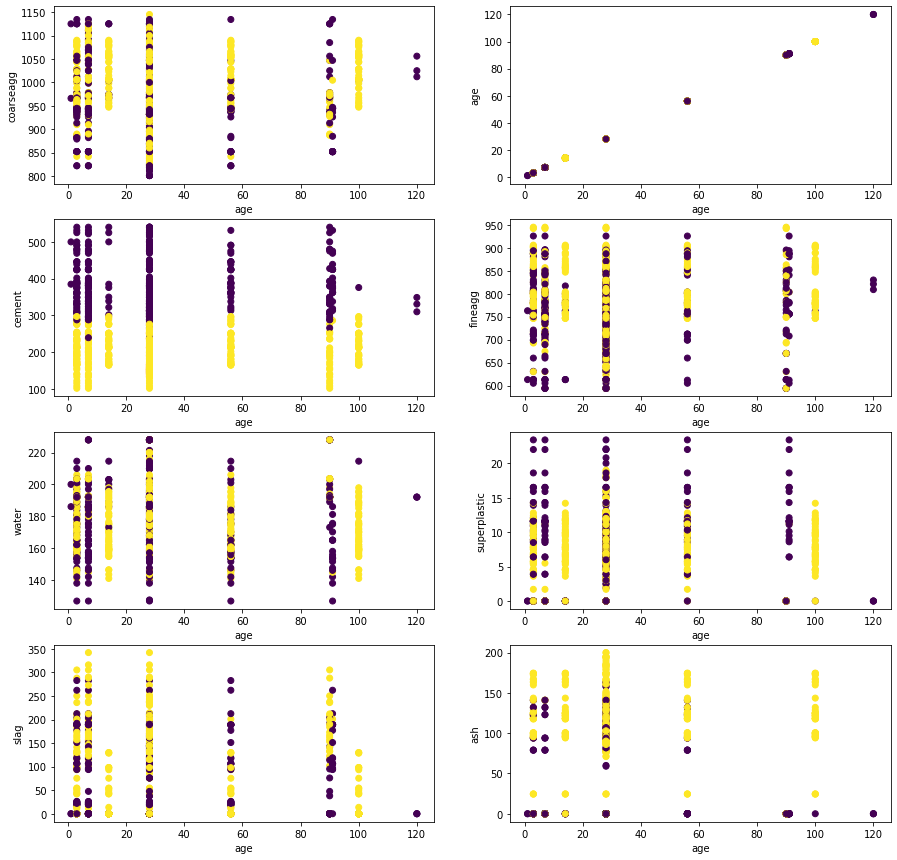

In [43]:
x = df.drop('strength',axis=1)
for col in x.columns:
    clustering(x,col,cluster)

In [44]:
new_df = df.join(pd.DataFrame(cluster,columns=['cluster']),how='left')
new_df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,cluster
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89,1
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51,1
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22,1
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85,0
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29,1


In [45]:
info = new_df.groupby('cluster')['cement'].agg(['mean','median'])
info

,mean,median
cluster,,
0,376.731317,362.6
1,203.132804,202.0


In [46]:
cluster_df = new_df.merge(info,on='cluster',how='left')
cluster_df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,cluster,mean,median
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89,1,203.132804,202.0
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51,1,203.132804,202.0
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22,1,203.132804,202.0
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85,0,376.731317,362.6
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29,1,203.132804,202.0


In [48]:
multiple_models(cluster_df,'strength')

,Model name,RMSE,R2 score
8,GB Regression,5.297031,0.893314
6,RF Regression,5.326879,0.892108
3,DT Regression,6.654721,0.831615
7,ADB Regression,8.474407,0.726938
0,Linear Regression,8.894347,0.699204
2,Ridge Regression,8.894349,0.699204
1,Lasso,8.902736,0.698637
4,KN Regression,8.961329,0.694657
5,SV Regression,14.035678,0.250951
9,XGB Regression,14.035678,0.250951


In [49]:
k_fold_cv(cluster_df.drop('strength',axis=1),cluster_df['strength'])

,Model Name,Avg. R2,STD R2 score
3,XGboost,0.899436,0.046856
6,Random Forest,0.888196,0.034291
4,Gradient,0.875348,0.044909
7,DTR,0.834446,0.056341
5,Adaboost,0.740073,0.039086
0,Linear Reg.,0.686729,0.062316
2,Ridge,0.686641,0.062314
1,Lasso,0.686437,0.062413
8,KNN,0.669395,0.088242
9,SVR,0.238550,0.045211


In [50]:
cv_hpt(cluster_df.drop('strength',axis=1),cluster_df['strength'])

,Model Name,Avg. R2,STD R2 score
3,XGboost,0.901786,0.043815
6,Random Forest,0.888156,0.035906
4,Gradient,0.875581,0.045051
7,DTR,0.834092,0.056396
5,Adaboost,0.743656,0.040909
0,Linear Reg.,0.686729,0.062316
2,Ridge,0.686641,0.062314
1,Lasso,0.686437,0.062413
8,KNN,0.669395,0.088242
9,SVR,0.238550,0.045211


## Feature Importance 

In [51]:
x_train,x_test,y_train,y_test = train_and_test_split(cluster_df,'strength')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

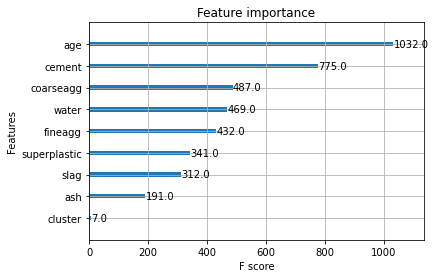

In [52]:
xgb = XGBRegressor(alpha=1,gamma=0,reg_lambda=1)
xgb.fit(x_train,y_train)
xgboost.plot_importance(xgb)

In [53]:
imp_df = cluster_df[['age','cement','coarseagg','water','strength']]
imp_df.head()

,age,cement,coarseagg,water,strength
0,28,141.3,971.8,203.5,29.89
1,14,168.9,1080.8,158.3,23.51
2,28,250.0,956.9,187.4,29.22
3,28,266.0,932.0,228.0,45.85
4,28,154.8,1047.4,193.3,18.29


In [54]:
cv_hpt(imp_df.drop('strength',axis=1),imp_df['strength'])

,Model Name,Avg. R2,STD R2 score
3,XGboost,0.864373,0.047920
6,Random Forest,0.839329,0.047396
4,Gradient,0.815144,0.043119
7,DTR,0.741343,0.083051
5,Adaboost,0.685368,0.038721
8,KNN,0.662576,0.066705
1,Lasso,0.570664,0.065825
2,Ridge,0.570613,0.066400
0,Linear Reg.,0.570613,0.066400
9,SVR,0.270158,0.045718


## Learning Curve Analysis

In [55]:
def glc(model_name,estimator,x,y):
    train_size , train_score, test_score = learning_curve(estimator=estimator,X=x,y=y,cv=10)
    train_score_mean = np.mean(train_score,axis=1)
    test_score_mean = np.mean(test_score,axis=1)
    plt.plot(train_size,train_score_mean,c='blue')
    plt.plot(train_size,test_score_mean,c='red')
    plt.xlabel('samples')
    plt.ylabel('R2 Score')
    plt.title('Learning Curve for'+model_name)
    plt.legend(('Training score','Testing score'))
    

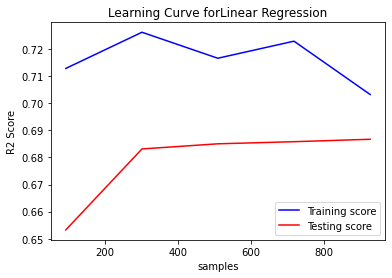

In [56]:
glc('Linear Regression',LinearRegression(),cluster_df.drop('strength',axis=1),cluster_df['strength'])

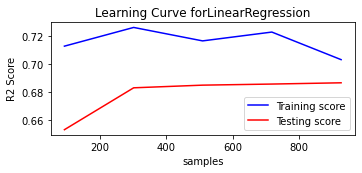

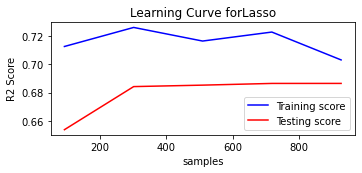

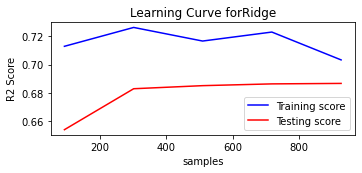

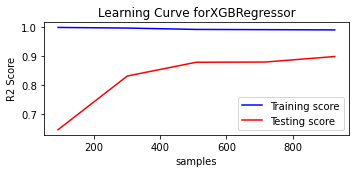

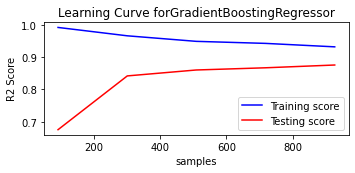

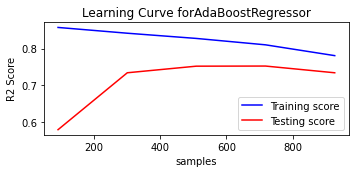

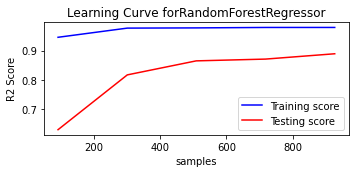

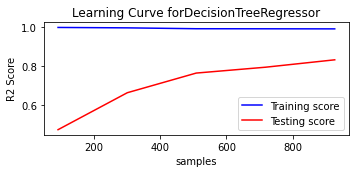

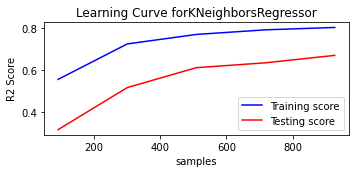

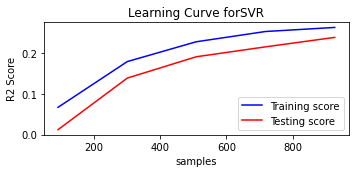

In [57]:
models = [LinearRegression(),Lasso(),Ridge(),XGBRegressor(),GradientBoostingRegressor(),AdaBoostRegressor(),RandomForestRegressor(),DecisionTreeRegressor(),KNeighborsRegressor(),SVR()]
for a,model in enumerate(models):
    a,model
    fg = plt.figure(figsize=(12,12))
    ax = fg.add_subplot(5,2,a+1)
    glc(type(models[a]).__name__,model,cluster_df.drop('strength',axis=1),cluster_df['strength'])